In [1]:
max_words = 200
max_len = 40
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

import pandas as pd

In [2]:
df_train = pd.read_excel("отзывы за лето.xls")
df_train.head(10)

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
5,5,Всё удобно норм 👍👍👍,2017-08-14
6,5,Очень удобное приложение.,2017-08-14
7,5,Все устраивает,2017-08-14
8,5,У меня работает все четко. В отличии от банком...,2017-08-14
9,5,Очень все хорошо👍,2017-08-14


In [3]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [4]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['Content'] = df_train['Content'].apply(preprocess_text)

X = df_train['Content']
y = df_train['Rating']

from sklearn import model_selection
X_train, X_test, Y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

train_corpus = " ".join(X_train)
train_corpus = train_corpus.lower()

In [5]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to /Users/rozhnov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
tokens_filtered = [word for word in tokens if word.isalnum()]
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]


In [7]:
tokens_filtered_top[:10]

['приложение',
 'удобно',
 'работать',
 'удобный',
 'отлично',
 'нравиться',
 'хороший',
 'отличный',
 'телефон',
 'супер']

In [8]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [9]:
import numpy as np

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [10]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_train['Content']], dtype=np.int32)
x_train.shape

(16527, 40)

In [11]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  

In [12]:
num_classes = 6
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_val = keras.utils.to_categorical(df_train['Rating'], num_classes)

In [13]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/20
 1/30 [>.............................] - ETA: 0s - loss: 1.8157 - accuracy: 0.0488WARNING:tensorflow:From /Users/rozhnov/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 4s 139ms/step - loss: 1.4100 - accuracy: 0.6670 - val_loss: 0.9538 - val_accuracy: 0.7217
Epoch 2/20
30/30 [==============================] - 4s 119ms/step - loss: 0.9350 - accuracy: 0.7230 - val_loss: 0.7940 - val_accuracy: 0.7695
Epoch 3/20
30/30 [==============================] - 4s 125ms/step - loss: 0.7725 - accuracy: 0.7572 - val_loss: 0.6968 - val_accuracy: 0.7713
Epoch 4/20
30/30 [==============================] - 4s 138ms/step - loss: 0.7010 - accuracy: 0.7644 - val_loss: 0.6678 - val_accuracy: 0.7792
Epoch 5/20
30/30 [==============================] - 4s

In [16]:
score = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

41/41 [==============================] - 2s 48ms/step - loss: 0.6299 - accuracy: 0.7828


Test score: 0.6299067139625549
Test accuracy: 0.7827581167221069


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score 

In [18]:
vect = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', lowercase=False)

In [19]:
train_ft = vect.fit_transform(X_train)
valid_ft = vect.transform(df_train['Content'])

In [20]:
lgr = LogisticRegression()
lgr.fit(train_ft, Y_train.to_numpy())

/Users/rozhnov/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
y_pred = lgr.predict(valid_ft)
accuracy_score(y.to_numpy(), y_pred)

0.8232247446633428

In [27]:
from gensim.models import Word2Vec
modelW2V = Word2Vec(sentences=df_train['Content'].apply(str.split), size=100, window=5, min_count=5, workers=8)

In [29]:
vect_idf = TfidfVectorizer()
vect_idf.fit_transform(df_train['Content'])
tfidf = dict(zip(vect_idf.get_feature_names(), vect_idf.idf_))

In [33]:
rt = vect_idf.vocabulary_.items()

In [34]:
from collections import defaultdict

In [35]:
max_idf = max(vect_idf.idf_)

word2weight = defaultdict(
    lambda: max_idf,
    [(w, vect_idf.idf_[i]) for w, i in vect_idf.vocabulary_.items()])

In [36]:
def get_vect_mean(txt):
    vector_w2v = np.zeros(100)
    n_w2v = 0
    for wrd in txt.split():
        if wrd in modelW2V:
            vector_w2v += modelW2V[wrd]
            n_w2v += 1
    if n_w2v > 0:
        vector_w2v = vector_w2v / n_w2v
    return vector_w2v

def get_vect_idf(txt):
    vector_w2v = np.zeros(100)
    n_w2v = 0
    for wrd in txt.split():
        if wrd in modelW2V:
            iddf_ = tfidf.get(wrd, 1.)
            vector_w2v += modelW2V[wrd]*iddf_
            n_w2v += iddf_
    if n_w2v > 0:
        vector_w2v = vector_w2v / n_w2v
    return vector_w2v

In [37]:
from tqdm import tqdm_notebook

In [50]:
arr_vect = []
for txt in tqdm_notebook(X_train):
    arr_vect.append(get_vect_mean(txt))
    
arr_vect_valid = []
for txt in tqdm_notebook(df_train['Content']):
    arr_vect_valid.append(get_vect_mean(txt))
    
train_w2v = np.asarray(arr_vect)    
valid_w2v = np.asarray(arr_vect_valid)

<ipython-input-50-df1712ae5cac>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for txt in tqdm_notebook(X_train):


<ipython-input-36-e89a2fe47eca>:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if wrd in modelW2V:
<ipython-input-36-e89a2fe47eca>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector_w2v += modelW2V[wrd]


<ipython-input-50-df1712ae5cac>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for txt in tqdm_notebook(df_train['Content']):


In [40]:
lgr_w2v = LogisticRegression()
lgr_w2v.fit(train_w2v, Y_train.to_numpy())

/Users/rozhnov/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [43]:
y_pred = lgr_w2v.predict(valid_w2v)
accuracy_score(y.to_numpy(), y_pred)

0.7421462800716395

In [44]:
arr_vect = []
for txt in tqdm_notebook(X_train):
    arr_vect.append(get_vect_idf(txt))
    
arr_vect_valid = []
for txt in tqdm_notebook(df_train['Content']):
    arr_vect_valid.append(get_vect_idf(txt))
    
train_w2v = np.asarray(arr_vect)    
valid_w2v = np.asarray(arr_vect_valid)

<ipython-input-44-3fd449c2466d>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for txt in tqdm_notebook(X_train):


<ipython-input-36-e89a2fe47eca>:16: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if wrd in modelW2V:
<ipython-input-36-e89a2fe47eca>:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector_w2v += modelW2V[wrd]*iddf_


<ipython-input-44-3fd449c2466d>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for txt in tqdm_notebook(df_train['Content']):


In [51]:
lgr_w2v = LogisticRegression()
lgr_w2v.fit(train_w2v, Y_train.to_numpy())
y_pred = lgr_w2v.predict(valid_w2v)

/Users/rozhnov/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
accuracy_score(y.to_numpy(), y_pred)

0.7421462800716395

### Нейросеть

In [54]:
import random
import torch
import torch.nn as nn

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [55]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [56]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [60]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()

    
train_dataset = DataWrapper(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # data = data.cuda()
        # target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        target = torch.argmax(target, dim=1)
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history.append(loss)

Net(
  (embedding): Embedding(200, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=6, bias=True)
)
Parameters: 75654
Train epoch 1/20
Step 0: loss=1.6116347312927246
Train epoch 2/20
Step 0: loss=0.7282378077507019
Train epoch 3/20
Step 0: loss=0.5747666954994202
Train epoch 4/20
Step 0: loss=0.5657120943069458
Train epoch 5/20
Step 0: loss=0.4742121994495392
Train epoch 6/20
Step 0: loss=0.5286418795585632
Train epoch 7/20
Step 0: loss=0.41174596548080444
Train epoch 8/20
Step 0: loss=0.33086180686950684
Train epoch 9/20
Step 0: loss=0.3667222857475281
Train epoch 10/20
Step 0: loss=0.36188963055610657
Train epoch 11/20
Step 0: loss=0.3218509256839752
Train epoch 12/20
Step 0: loss=0.3637925386428833
Train epoch 13/20
Step 0: loss=0.29337257146835327
Train epoch 14/20
Step 0: loss=0.3148404061794281
Train epoch 15/20
Step 0: loss=0.33569779992103577
Train epoch 16/20
Step 0: loss=0.3980589210987091
Train 

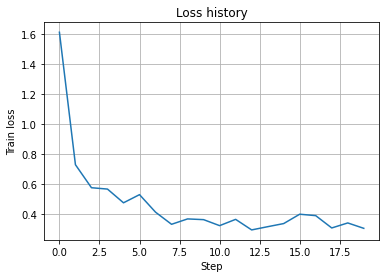

In [61]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history);